In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastparquet
import gc
import cPickle as pickle

In [3]:
stores_idx,items_idx,days_idx,states,cities,families,types = pickle.load(open("array_index.pkl"))

In [4]:
dim=(54, 4100, 1704)

In [5]:
def get_series(name):
    a=np.load("../input/s4/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b
def get_series2(name):
    a=np.load("../input/s4/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==(4100, 54, 1704)
    return b
def save_series(arr,name):
    assert arr.shape==dim
    print arr.dtype, arr.nbytes/1024.0**2
    np.savez_compressed("../input/s4/"+name, arr)
def save_series2(arr,name):
    print arr.dtype, arr.nbytes/1024.0**2
    np.savez_compressed("../input/s4/"+name, arr)    
def s_lag(arr,lag=1):
    l,m,n=arr.shape
    assert lag>0 and lag<n
    a=arr[:,:,:-lag]
    b=np.empty(shape=[l,m,lag],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([b,a],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba

def forward(arr,step=1):
    l,m,n=arr.shape
    assert step>0 and step<n
    a=arr[:,:,step:]
    b=np.empty(shape=[l,m,step],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([a,b],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba

In [6]:
def moving_average_axis3(a, n=3,nan_periods=None):
    a=a.copy()
    assert len(a.shape)==3
    if nan_periods is None: nan_periods=n/2
    nanidx=np.isnan(a)
    a[nanidx]=0
    l,m,_=a.shape
    cusum_a = np.concatenate([np.zeros(shape=[l,m,n]),np.cumsum(a, axis=2,dtype=float)],axis=2)
    cusum_a_cnt=np.concatenate([np.zeros(shape=[l,m,n]),np.cumsum(~nanidx,axis=2, dtype=float)],axis=2)
    b=cusum_a[:,:,(n-0):]-cusum_a[:,:,:-(n-0)]
    c=cusum_a_cnt[:,:,n-0:]-cusum_a_cnt[:,:,:-(n-0)]
    c[c<=nan_periods]=np.nan
    ret=(b/c)
    #pad=np.empty(shape=[l,m,n-1],dtype=ret.dtype)
    #pad.fill(np.nan)
    #ret=np.concatenate([pad,ret],axis=2)
    assert ret.shape==a.shape, ret.shape
    return ret

In [7]:
def nan_equal(a,b):
    ret=( (np.abs(a - b)<1e1) | (numpy.isnan(a) & numpy.isnan(b)))
    #print np.where(~ret)
    #print a[~ret]
    #print b[~ret]
    return ret.all()
def test_mv():
    for i in range(30):
        print i,
        a=y0[i]
        df=pd.DataFrame(a.T,dtype=np.float64)
        b=pd.rolling_mean(df,window=3,min_periods=3/2+1).values
        c=y_mv3[i].T
        #print df.shape,b.shape,c.shape
        #print np.nansum(np.abs(b-c))
        assert nan_equal(b,c)        

In [8]:
def season_ma_axis3(arr,season=3,window=5,nan_periods=None):
    assert len(arr.shape)==3
    arr=arr.copy()
    if nan_periods is None: nan_periods=window/2
    arr_sum=arr.astype(np.float64,copy=True)
    arr_sum[np.isnan(arr_sum)]=0
    arr_nan=(~np.isnan(arr)).astype(np.float)
    for i in range(1,window):
        laged=s_lag(arr,lag=season*window)
        laged[np.isnan(laged)]=0
        #print laged
        arr_sum+=laged
        arr_nan+=~np.isnan(laged)
    #print arr_sum
    #print arr_nan
    arr_nan[arr_nan<=nan_periods]=np.nan  
    ret=arr_sum/arr_nan
    assert ret.shape==arr.shape
    return ret

In [9]:
def nan_mean(x):
    return np.nanmean(x,dtype=float)
def nonnan_mean(x):
    return np.mean(x,dtype=float)

In [10]:
y0=get_series("y_0")

In [11]:
y0.shape,np.mean(np.isnan(y0)),nan_mean(y0)

((54, 4100, 1704), 0.48402279190045422, 0.64465711630350631)

# nan flag

In [12]:
YEAR=[ 358,  365,  723,  730, 1088, 1095, 1454, 1461]
data=np.isnan(y0).astype(np.float16)
data[:,:,YEAR]=0
print data.nbytes/1024.0**2,nonnan_mean(data),nan_mean(y0)
save_series(data,'nan_flag')

719.577026367 0.480602928017 0.644657116304
float16 719.577026367


# year_flag

In [13]:
data=np.zeros_like(y0)
data[:,:,YEAR]=1
print data.nbytes/1024.0**2,nonnan_mean(data),nan_mean(y0)
save_series(data,'year_flag')

719.577026367 0.00469483568075 0.644657116304
float16 719.577026367


In [14]:
from scipy.ndimage.interpolation import shift
def nancorr(a,b):
    ind=~np.isnan(a)
    ind &= ~np.isnan(b)
    return np.corrcoef(a[ind].astype(np.float),b[ind].astype(np.float))[0,1]

## store_item mean

In [15]:
a=np.nanmean(np.reshape(y0,(-1,1704)),axis=0,dtype=np.float).astype(np.float16)
a[np.isnan(a)]=0

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


(array([ 358,  365,  723,  730, 1088, 1095, 1454, 1461, 1688, 1689, 1690,
        1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701,
        1702, 1703]),)

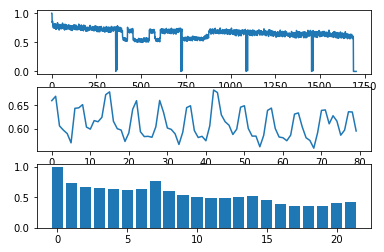

In [16]:
f, axarr = plt.subplots(3, 1)
axarr[0].plot(a)
axarr[1].plot(a[1600:1680])
axarr[2].bar(range(22), [nancorr(a,shift(a.astype(np.float),i,cval=np.nan)) for i in range(22)]);
np.where(a<0.1)

In [17]:
data=np.ones_like(y0)*a
print data.nbytes/1024.0**2,nonnan_mean(data),nan_mean(y0)
save_series(data,'store_item_mean')


719.577026367 0.647137946366 0.644657116304
float16 719.577026367


## store_mean

In [18]:
a=np.nanmean(y0,axis=1,dtype=np.float).astype(np.float16)
a[np.isnan(a)]=0
a.shape

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


(54, 1704)

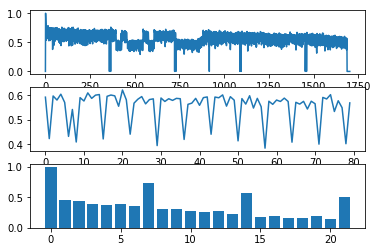

In [19]:
f, axarr = plt.subplots(3, 1)
axarr[0].plot(a[0])
axarr[1].plot(a[0][1600:1680])
axarr[2].bar(range(22), [nancorr(a[0],shift(a[0].astype(np.float),i,cval=np.nan)) for i in range(22)]);

In [20]:
data=np.ones_like(y0)*np.expand_dims(a,1)
print data.nbytes/1024.0**2,nonnan_mean(a)
save_series(data,'store_mean')


719.577026367 0.592485016355
float16 719.577026367


## item_mean

In [21]:
import cPickle as pickle
stores_idx,items_idx,days_idx,states,cities,families,types = pickle.load(open("array_index.pkl"))
rev_stores={v:u for u,v in stores_idx.items()}
rev_items={v:u for u,v in items_idx.items()}
rev_days={v:u for u,v in days_idx.items()}


In [22]:
# %load ./../functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind
def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

In [23]:
a=np.nanmean(y0,axis=0,dtype=np.float).astype(np.float16)
a[np.isnan(a)]=0
a.shape

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


(4100, 1704)

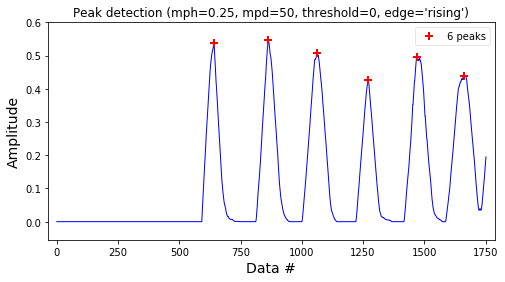

(array([ 642,  864, 1064, 1271, 1471, 1662]),
 204.0,
 [Timestamp('2014-10-05 00:00:00', freq='D'),
  Timestamp('2015-05-15 00:00:00', freq='D'),
  Timestamp('2015-12-01 00:00:00', freq='D'),
  Timestamp('2016-06-25 00:00:00', freq='D'),
  Timestamp('2017-01-11 00:00:00', freq='D'),
  Timestamp('2017-07-21 00:00:00', freq='D')])

In [53]:
peaks=detect_peaks(smooth(b,window_len=50,window='flat'), mph=0.25, mpd=50, threshold=-0, valley=False, show=True)
peaks,diff(peaks).mean(), [rev_days[u] for u in peaks]

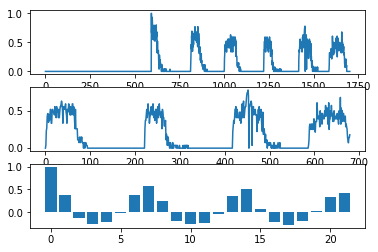

In [17]:
f, axarr = plt.subplots(3, 1)
b=a[1]
axarr[0].plot(b)
axarr[1].plot(b[1000:1680])
axarr[2].bar(range(22), [nancorr(b,shift(b.astype(np.float),i*30,cval=np.nan)) for i in range(22)]);

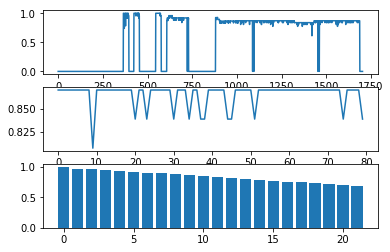

In [69]:
f, axarr = plt.subplots(3, 1)
b=a[int(random.random()*4000)]
axarr[0].plot(b)
axarr[1].plot(b[1600:1680])
axarr[2].bar(range(22), [nancorr(b,shift(b.astype(np.float),i,cval=np.nan)) for i in range(22)]);

In [24]:
data=np.ones_like(y0)*np.expand_dims(a,0)
print (data.nbytes/1024.0**2,nonnan_mean(a))
save_series(data,'item_mean')


719.577026367 0.451629250519
float16 719.577026367


In [25]:
def h():
    for i in [3,7,14,28,56,112,224]:
        name = "y_ma_{}".format(i)
        print (name)
        y_ma=moving_average_axis3(y0,i).astype(np.float16)
        y_ma[np.isnan(y_ma)]=0
        save_series(y_ma,name)

In [26]:
h()

y_ma_3
float16 719.577026367
y_ma_7
float16 719.577026367
y_ma_14
float16 719.577026367
y_ma_28
float16 719.577026367
y_ma_56
float16 719.577026367
y_ma_112
float16 719.577026367
y_ma_224
float16 719.577026367


### seasonal series

In [27]:
def h():
    for p in [2,3,4,7,13]:
        name="sales_week_season_ma_p"+str(p)
        s=season_ma_axis3(y0,season=7,window=p).astype(np.float16)
        s[np.isnan(s)]=0        
        print (name)
        save_series(s,name)


In [28]:
h()

sales_week_season_ma_p2
float16 719.577026367
sales_week_season_ma_p3
float16 719.577026367
sales_week_season_ma_p4
float16 719.577026367
sales_week_season_ma_p7
float16 719.577026367
sales_week_season_ma_p13
float16 719.577026367


### cat related

In [29]:
cats=['city', 'item_nbr', 'cluster', 'store_nbr', 'state', 'type', 'class']
dim

(54, 4100, 1704)

In [30]:
np.isnan(y0).mean()

0.48402279190045422

In [31]:
store_mean=np.nanmean(y0.astype(np.float64),axis=1,keepdims=True)

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [32]:
store_mean_s=(np.ones(dim)*store_mean).astype(np.float16)

In [33]:
store_mean.shape,store_mean_s.shape

((54, 1, 1704), (54, 4100, 1704))

In [34]:
item_mean=np.nanmean(y0.astype(np.float64),axis=0,keepdims=True)

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [35]:
item_mean_s=(np.ones(dim)*item_mean).astype(np.float16)

In [36]:
item_mean_s.shape,item_mean.shape,np.rollaxis(item_mean_s,1,0).shape

((54, 4100, 1704), (1, 4100, 1704), (4100, 54, 1704))

In [37]:
stores=pd.read_csv("../input/stores.csv",index_col=0)
stores.index=stores.index.map(lambda u: stores_idx[u])

In [38]:
store_mean.shape

(54, 1, 1704)

In [39]:
def f(col):
    m=stores[col].to_dict()
    this_store_mean=store_mean.astype(np.float64)
    obj_dict={k:[] for k in set(m.values())}
    for store_nbr,obj in m.items():
        obj_dict[obj].append(this_store_mean[store_nbr][0])
    obj_dict={k:np.nanmean(v,0) for k,v in obj_dict.items()}
    print ([(k,v.shape) for k,v in obj_dict.items()])
    a=np.array([ obj_dict[m[i]] for i in  range(len(stores))])
    a=np.expand_dims(a,1)
    print (a.shape)
    return (np.ones(dim) * a).astype(np.float16)

In [40]:
for col in ['city',   'cluster',   'state', 'type']:
    arr=f(col)
    save_series(arr, col)

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice


[('Loja', (1704,)), ('Ibarra', (1704,)), ('Playas', (1704,)), ('Guaranda', (1704,)), ('Daule', (1704,)), ('Riobamba', (1704,)), ('El Carmen', (1704,)), ('Libertad', (1704,)), ('Manta', (1704,)), ('Quito', (1704,)), ('Salinas', (1704,)), ('Cuenca', (1704,)), ('Latacunga', (1704,)), ('Puyo', (1704,)), ('Ambato', (1704,)), ('Babahoyo', (1704,)), ('Esmeraldas', (1704,)), ('Guayaquil', (1704,)), ('Cayambe', (1704,)), ('Santo Domingo', (1704,)), ('Machala', (1704,)), ('Quevedo', (1704,))]
(54, 1, 1704)
float16 719.577026367
[(1, (1704,)), (2, (1704,)), (3, (1704,)), (4, (1704,)), (5, (1704,)), (6, (1704,)), (7, (1704,)), (8, (1704,)), (9, (1704,)), (10, (1704,)), (11, (1704,)), (12, (1704,)), (13, (1704,)), (14, (1704,)), (15, (1704,)), (16, (1704,)), (17, (1704,))]
(54, 1, 1704)
float16 719.577026367
[('Pastaza', (1704,)), ('El Oro', (1704,)), ('Loja', (1704,)), ('Santo Domingo de los Tsachilas', (1704,)), ('Santa Elena', (1704,)), ('Pichincha', (1704,)), ('Cotopaxi', (1704,)), ('Azuay', (1

In [41]:
item_mean.shape

(1, 4100, 1704)

In [42]:
items=pd.read_csv('../input/items.csv',index_col=0)
items.index=items.index.map(lambda u: items_idx[u])

In [43]:
def f(col):
    m=items[col].to_dict()
    this_item_mean=item_mean.astype(np.float64)
    obj_dict={k:[] for k in set(m.values())}
    for store_nbr,obj in m.items():
        obj_dict[obj].append(this_item_mean[0][store_nbr])
    obj_dict={k:np.nanmean(v,0) for k,v in obj_dict.items()}
    print  ([(k,v.shape) for k,v in obj_dict.items()][:10])
    a=np.array([ obj_dict[m[i]] for i in  range(len(items))])
    a=np.expand_dims(a,0)
    print (a.shape)
    ret=(np.ones(dim) * a).astype(np.float16)
    return np.rollaxis(ret,1,0)

In [44]:
for col in ['family',   'class']:
    arr=f(col)
    save_series2(arr, col)

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice


[('PLAYERS AND ELECTRONICS', (1704,)), ('HOME AND KITCHEN I', (1704,)), ('AUTOMOTIVE', (1704,)), ('SEAFOOD', (1704,)), ('GROCERY II', (1704,)), ('HARDWARE', (1704,)), ('BOOKS', (1704,)), ('CLEANING', (1704,)), ('FROZEN FOODS', (1704,)), ('LIQUOR,WINE,BEER', (1704,))]
(1, 4100, 1704)
float16 719.577026367
[(1024, (1704,)), (1025, (1704,)), (1026, (1704,)), (1027, (1704,)), (1028, (1704,)), (1029, (1704,)), (1030, (1704,)), (1032, (1704,)), (1033, (1704,)), (1034, (1704,))]
(1, 4100, 1704)
float16 719.577026367


In [45]:
items.shape,len(set(items.family)),len(set(items['class']))

((4100, 3), 33, 337)

In [46]:
for col in ['city',   'cluster',   'state', 'type']:
    s=get_series(col)
    s2=moving_average_axis3(s,n=36).astype(np.float16)
    save_series(s2,col+"_mv36")

float16 719.577026367
float16 719.577026367
float16 719.577026367
float16 719.577026367


In [47]:
for col in ['family',   'class']:
    s=get_series2(col)
    s2=moving_average_axis3(s,n=36).astype(np.float16)
    print (s2.shape)
    save_series2(s2,col+"_mv36")

(4100, 54, 1704)
float16 719.577026367
(4100, 54, 1704)
float16 719.577026367


In [48]:
len(days_idx)

1704

In [49]:
import calendar
def g(d):
    return (d.day==15) or  d.day==calendar.monthrange(d.year,d.month)[1]
def fillna_wage_forward(s):
    lst=[]
    curr_holiday=None
    for i in range(len(s)):
        if s.iloc[i]:
            curr_holiday=i
        if curr_holiday is not None :
            lst.append((i-curr_holiday)/15.0)
        else:
            lst.append(0)
    return pd.Series(lst,index=s.index)

In [50]:
dates=pd.Series(days_idx).to_frame().sort_index()
dates=dates.reindex(pd.date_range(dates.index.min()-pd.Timedelta(days=30), dates.index.max()))
dates['wageday']=dates.index.map(g)
dates['wage_val']=fillna_wage_forward(dates['wageday'])
dates=dates.dropna().sort_index()
dates.shape

(1704, 3)

In [51]:
arr=np.expand_dims(np.expand_dims(dates['wage_val'].values,0),0)*np.ones(dim)
arr.shape

(54, 4100, 1704)

In [52]:
save_series(arr.astype(np.float16),"wage")

float16 719.577026367


In [53]:
import gc
gc.collect()

15009